In [ ]:
#!pip install GitPython textblob nltk pandas seaborn matplotlib   --quiet

In [ ]:
# repo = Repo.clone_from("https://github.com/pola-rs/polars", "./_git_polars_/")

In [ ]:
# !rm -rf _git_pandas_
# !rm -rf _git_polars_

### Loading data and preprocessing

In [ ]:
import re
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from git import Repo

sns.set_theme(context="notebook")

pd.options.display.max_colwidth = 300


## clone the repo 
repo = Repo.clone_from("https://github.com/pandas-dev/pandas.git", "./_git_pandas_/")

## with existing repo 
# repo=Repo("./_git_pandas_/")

In [ ]:
# reading commit messages
commits = list(repo.iter_commits("main"))
commit_details = [
    (commit.committed_datetime.timestamp(), commit.author.email.lower(), commit.message)
    for commit in commits
]
df = pd.DataFrame(commit_details)
df.columns = ["date", "email", "message"]
df["date"] = df["date"].astype("datetime64[s]")

# obfuscating emails
df["email"] = df["email"].apply(
    lambda x: "".join([chr(ord(l) + 1) for l in x.split("@")[0]])[:6]
    + "@"
    + "".join(x.split("@")[1:])
)

In [ ]:
df.head(4)

In [ ]:
df.shape

In [ ]:
df.head(3)

In [ ]:
# clean messages, extract words in UPPER CASE , extract abbreviations
import re

def clean_message(message):
    # lower case, replace newlines, git-related words
    message = re.sub(
        r"merge pull request #\d+|\s+|\:|git|github|-svn-id|commit|\(\#\d+\)|\[pre\-\.ci\]|(\w+\-){3,}\w+\s+|http:.*.\s|[A-Za-z0-9_+,.]{1,}@([A-Za-z0-9_+,.]{1,}?(\.\w+)){3,}",
        " ",
        message,
    ).strip()

    message = re.sub(
        r"-",
        " ",
        message,
    ).strip()

    return message

df["raw"]=df['message']

df["message"] = df["message"].apply(clean_message)

In [ ]:
df.head(4)

In [ ]:
df["tkns_in_upper_case"] = df["message"].apply(
    lambda x: set(re.findall(" ([A-Z]{3,})", x))
)
df["ntkns_in_upper_case"] = df["tkns_in_upper_case"].str.len()

abbrv = list()
for cell in df[df["ntkns_in_upper_case"] > 0]["tkns_in_upper_case"].to_list():
    for tk in cell:
        abbrv.append(tk)

print("abbreviations extracted", len(abbrv), ", some examples:", abbrv[:10])
abbrv = pd.Series(abbrv).value_counts().head(50).index.to_list()
abbrv.extend(["AFAIK", "MANIFEST"])

df["abbrv"] = df["tkns_in_upper_case"].apply(
    lambda x: ",".join(x.intersection(set(abbrv)))
)

df["tkns_in_upper_case"] = df["tkns_in_upper_case"].apply(
    lambda x: ",".join(x.difference(set(abbrv)))
)
df["ntkns_in_upper_case"] = df["tkns_in_upper_case"].str.split(",").str.len()

In [ ]:
df[df["ntkns_in_upper_case"] > 3].head(1)

## Descriptive stats

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 5), sharex=True)
ax2 = ax.twinx()

df["period"] = df["date"].dt.to_period("1Y")
df.groupby("period").size().plot(
    ax=ax, kind="bar", title="Number of commits per year", position=1
)
df.groupby("period").agg(uniq_contrib=("email", "nunique")).plot(
    ax=ax2, kind="bar", width=0.2, grid=False, position=0, color="grey"
)
ax.set_ylabel("N-commits")
ax2.set_ylabel("N-uniq contributors")
plt.tight_layout()
plt.show()

In [ ]:
## ^ this might reflect the product phase

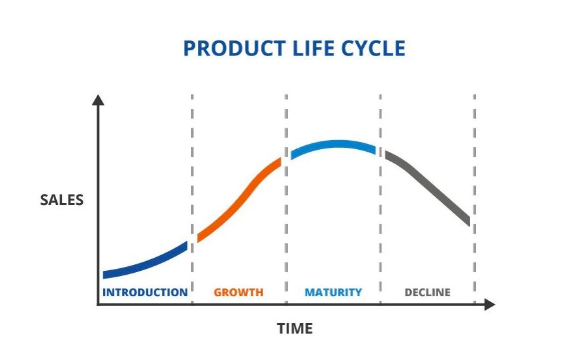

In [ ]:
# seasonality, when the project is progressing

fig, ax = plt.subplots(1)
df.groupby([df.date.dt.month, df.date.dt.year]).size().unstack().plot(
    ax=ax, kind="bar", stacked=True, title="Number of commits per month"
)
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5
)
plt.tight_layout()
plt.show()

In [ ]:
# main contributers
df["email"].value_counts(normalize=True).head(20).plot(
    kind="barh", title="main contributers"
)

## word frequencies 

In [ ]:
from collections import Counter

In [ ]:
all_words = " ".join(df["message"].to_list()).split()
common_words = Counter(all_words).most_common(1000)

In [ ]:
common_words[:20]

^ not very meaningfull , what we can do ?

In [ ]:
## Stop word - is a commonly used word, which doesn't add much of additional information

In [ ]:
from nltk.corpus import stopwords

In [ ]:
list(stopwords.words("english"))[:10]

In [ ]:
stopwords.words("english").extend(abbrv)

In [ ]:
[(word, count, word in stopwords.words("english")) for word, count in common_words][:20]

In [ ]:
# extending stop words

my_stopwords = set(stopwords.words("english"))
my_stopwords.update(
    {"fix", "add", "python", "type", "test", "text", "change", "file", "make", "master"}
)
my_stopwords.update(set(abbrv))

In [ ]:
[(word, count) for word, count in common_words if word not in my_stopwords][:20]

^ - we have same words here, like 'fixed' and 'fixes' ;   TODO: fine tune stop words - as not meaningfull 

## Tokenization, lemmatization 
Token - is the part of the text, i.e. sentence, word. Here we'll split text by word.

Lemma - is the root of the word, i.e.  "fixing" "fixed" "to fix"  would be transformed into a single word

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


def get_lemmas(text):
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stop_words = my_stopwords
    processed_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]
    return " ".join(processed_tokens)


def get_tagged_lemmas(text):
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stop_words = my_stopwords
    processed_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]

    tagged = nltk.tag.pos_tag(processed_tokens)
    return tagged

In [ ]:
df["message_lemmas"] = df["message"].apply(get_lemmas)

In [ ]:
df["message_tagged_lemmas"] = df["message"].apply(get_tagged_lemmas)

In [ ]:
df[["message", "message_lemmas", "message_tagged_lemmas"]].head(3)

In [ ]:
from collections import Counter

all_words = " ".join(df["message_lemmas"].to_list()).split()
common_words = Counter(all_words).most_common(1000)

In [ ]:
top_words=[(word, count) for word, count in common_words if word not in my_stopwords][:50]
top_words

In [ ]:
df[['message_lemmas','message']]

###  classifying commits by using lemmas

In [ ]:
df["is_bug"] = df["message_lemmas"].apply(
    lambda x: bool(
        [
            token
            for token in x.split(" ")
            if token in ["bug", "issue", "fix", "correct", "fixes", "fixed", "error"]
        ]
    )
)

In [ ]:
df = df.join(
    df[~df["is_bug"]]["message_lemmas"]
    .apply(
        lambda x: bool(
            [token for token in x.split(" ") if token in ["feature", "whatsnew", "new"]]
        )
    )
    .rename("is_feature")
)

In [ ]:
df["is_feature"] = df["is_feature"].fillna(False)

In [ ]:
# vocabulary
vocabulary = (
    df.set_index(["is_bug", "is_feature"])["message_lemmas"]
    .str.split(" ")
    .explode()
    .drop_duplicates()
    .reset_index()
)

In [ ]:
bug_vocab=list(vocabulary[vocabulary["is_bug"]]['message_lemmas'].unique())

In [ ]:
feature_vocab=list(vocabulary[vocabulary["is_feature"]]['message_lemmas'].unique())

In [ ]:
df.groupby("period")["is_bug"].sum().plot(kind="bar", position=0, color="red")
df.groupby("period")["is_feature"].sum().plot(
    kind="bar", position=1, color="green", title="number of bugs / features per year"
)
plt.legend()

## Triggering words 

In [ ]:
## lets search for any agressive or bad wourds in messages
bad_words = pd.read_csv("https://www.cs.cmu.edu/~biglou/resources/bad-words.txt")

In [ ]:
bad_words.columns = ["word"]

In [ ]:
bad_words = bad_words["word"].apply(WordNetLemmatizer().lemmatize).to_list()

In [ ]:
my_stopwords.update(
    {
        "failure",
        "black",
        "failed",
        "executed",
        "execute",
        "reject",
        "crash",
        "corruption",
    }
)

In [ ]:
df["bad_words"] = df["message_lemmas"].apply(
    lambda x: ",".join(
        list(
            set(
                token
                for token in x.split(" ")
                if all([token in bad_words, token not in my_stopwords])
            )
        )
    )
)

In [ ]:
df[df["bad_words"].str.len() > 0]["bad_words"].unique()

In [ ]:
df[df["bad_words"].str.len() > 0]["email"].value_counts().head(5)

In [ ]:
df[df["bad_words"] == "dumb"]

## Sentiment analysis 
example: lets search for very negative and very positive sentiment words

In [ ]:
from nltk.corpus import sentiwordnet as swn

In [ ]:
list(swn.senti_synsets("bug"))

In [ ]:
list(swn.senti_synsets("feature", "n"))[0].neg_score()

In [ ]:
list(swn.senti_synsets("exciting", "a"))[0].pos_score()

In [ ]:
swn_tagpos_mapping = {"NN": "n", "VBG": "s", "RB": "a", "FW": "n"}

In [ ]:
def get_neg_sentiments_by_word(text, threshold=0.80):
    tokens = set()

    if not text:
        return None

    for token, pos in text:
        try:
            if pos_ := swn_tagpos_mapping.get(pos):
                score = swn.senti_synsets(token, pos_).__next__().neg_score()
                if score > threshold:
                    tokens.add((token, pos, score))
        except Exception as e:
            pass

    if tokens:
        return tokens
    else:
        return None


def get_pos_sentiments_by_word(text, threshold=0.80):
    tokens = set()

    if not text:
        return None

    for token, pos in text:
        try:
            if pos_ := swn_tagpos_mapping.get(pos):
                score = swn.senti_synsets(token, pos_).__next__().pos_score()
                if score > threshold:
                    tokens.add((token, pos, score))
        except Exception as e:
            pass

    if tokens:
        return tokens
    else:
        return None

In [ ]:
df["neg_words"] = df["message_tagged_lemmas"].apply(
    lambda x: get_neg_sentiments_by_word(x, 0.5)
)

In [ ]:
df["pos_words"] = df["message_tagged_lemmas"].apply(
    lambda x: get_pos_sentiments_by_word(x, 0.5)
)

In [ ]:
df[df["neg_words"].notnull()]["neg_words"].value_counts()[:10]

In [ ]:
df[df["pos_words"].notnull()]["pos_words"].value_counts()[:10]

In [ ]:
## ^  - if these words and sentiments are not meaningfull, add these words into stopwords

In [ ]:
df["avg_neg_score"] = df["neg_words"].apply(
    lambda x: sum([w[2] for w in x]) / len(x) if x else 0
)

df["avg_pos_score"] = df["pos_words"].apply(
    lambda x: sum([w[2] for w in x]) / len(x) if x else 0
)

df["one"] = 1

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True)
df = df.set_index(df["date"].dt.date).sort_index()
df["avg_pos_score"].cumsum().plot(ax=ax, color="green")
df["avg_neg_score"].cumsum().plot(
    ax=ax, linestyle="--", color="red", title="pos/neg sentiment"
)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
n = 10
top_contributors_emails = df.value_counts("email")[:n].index.to_list()

top_contributors = df[df["email"].isin(top_contributors_emails)]

top_contributors = (
    top_contributors.groupby(["email", "period"])
    .aggregate(
        commits=("avg_neg_score", "count"),
        neg_score=("avg_neg_score", "sum"),
        pos_score=("avg_pos_score", "sum"),
    )
    .assign(ratio=lambda x: x["neg_score"] / x["commits"])
    .assign(ratio_pos=lambda x: x["pos_score"] / x["commits"])
)

top_contributors


In [ ]:
fig, ax = plt.subplots(1)
top_contributors.swaplevel()["ratio"].unstack().plot(ax=ax, kind="bar", stacked=True)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=2,
    title="neg sentiment ratio per contributer",
)
plt.tight_layout()
plt.show()

In [ ]:
## ^ outcome: first year commits are usually having higher negative sentiment ratio, than later years

## Sentiments - TextBlob

In [ ]:
import textblob #it is awesome library 

In [ ]:
textblob.Sentence("i love coffee, its awesome").sentiment

In [ ]:
df["polarity"] = df["message"].apply(lambda x: textblob.Sentence(x).polarity)
df["subjectivity"] = df["message"].apply(lambda x: textblob.Sentence(x).subjectivity)
df.sort_values(["polarity"]).head(3)

In [ ]:
df = df.set_index("date")

In [ ]:
df.where(df["polarity"] > 0.5)["polarity"].resample("Y").sum().plot(
    color="green", kind="bar"
)
df.where(df["polarity"] < -0.5).groupby("period")["polarity"].sum().plot(
    color="red", kind="bar", title="polarity by year"
)
plt.show()

In [ ]:
import matplotlib.dates as mdates

fig = (
    df[df["is_bug"]]
    .groupby("period")["polarity"]
    .sum()
    .diff()
    .rename("bug")
    .plot(color="red", kind="bar", position=0, width=0.3)
)

fig = (
    df[df["is_feature"]]
    .groupby("period")["polarity"]
    .sum()
    .diff()
    .rename("feature")
    .plot(
        color="green",
        kind="bar",
        width=0.3,
        position=1,
        title="polarity change by year",
    )
)
fig.legend()
plt.tight_layout()

In [ ]:
top_contributors = df[df["email"].isin(top_contributors_emails)]

top_contributors = (
    top_contributors.groupby("email")
    .aggregate(
        commits=("email", "count"),
        polarity=("polarity", "sum"),
        subjectivity=("subjectivity", "sum"),
    )
    .assign(
        polarity_ratio=lambda x: x["polarity"] / x["commits"],
        subjectivity_ratio=lambda x: x["subjectivity"] / x["commits"],
    )
    .sort_values("polarity_ratio", ascending=False)
)

In [ ]:
top_contributors

In [ ]:
import numpy as np

In [ ]:
# polarity per year, taking only  abs(0.5)

df.groupby("period").agg(
    stressed_day_polarity_score=("polarity", "sum"),
    n_commits=("email", "count"),
    neg_polarity_n_commits=("polarity", lambda x: sum(x < -0.5)),
    pos_polarity_n_commits=("polarity", lambda x: sum(x > +0.5)),
    emails=("email", lambda x: Counter(x)),
).sort_values("neg_polarity_n_commits", ascending=False).head(5)

In [ ]:
# df[df['date'].between("2020-05-10","2020-05-10")].sort_values('polarity')

In [ ]:
# df['adj']=df['message_tagged_lemmas'].apply(lambda x: set([tk[0] for tk in x if 'RB' in tk[1]]))
fig,ax=plt.subplots(nrows=1, sharex=True, figsize=(7,4))
sns.ecdfplot(df[df['is_feature']], ax=ax,x='polarity', color='green')
sns.ecdfplot(df[df['is_bug']],  ax=ax, x='polarity', color='red')
plt.title('polarity of feature / bug')
plt.show()

## Deep Learning models for finding emotions 

In [ ]:
# classifier  = pipeline(
# model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
# truncation=True,
# )

In [ ]:
from transformers import pipeline

# # Load the BERT-Emotions-Classifier
# classifier = pipeline(
#     "text-classification", top_k=3,truncation=True, model="ayoubkirouane/BERT-Emotions-Classifier"
# )

classifier = pipeline(
    model="SamLowe/roberta-base-go_emotions",
    truncation=True,
    top_k=3,
    return_all_scores=True,
)

In [ ]:
text = ["exciting feature increases the capacity and speed"]
model_outputs = classifier(text, num_workers=8)
model_outputs

In [ ]:
def get_emotions(text):
    model_outputs = classifier(text)
    return {
        list(emotion.values())[0]: list(emotion.values())[1]
        for emotion in model_outputs[0]
    }

In [ ]:
get_emotions("i love the most annoying bug, which was crashing the app")

In [ ]:
sample = df.sample(2000)
cols = sample.shape[1]
sample = sample.join(sample["message"].apply(lambda x: pd.Series(get_emotions(x))))

In [ ]:
emotions=sample.iloc[:, cols:].columns
sample.iloc[:, cols:].sum().to_frame()

In [ ]:
sample.nlargest(5, "confusion")

In [ ]:
sample.nlargest(5, "disgust")

In [ ]:
sum_emotions=sample[sample['email'].isin(top_contributors_emails)].groupby('email')[emotions].sum()

In [ ]:
sum_emotions.style.format('{:,.2f}').background_gradient(cmap='RdYlGn_r', axis=1)

In [ ]:
sum_emotions.drop(columns=['neutral','approval']).style.format('{:,.2f}').highlight_max(color='red', axis=1)

In [ ]:
emotions_no_neut=set(emotions)
emotions_no_neut.remove('neutral')
emotions_no_neut.remove('approval')
emotions_no_neut=list(emotions_no_neut)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,7),sharex=True)
sample.groupby('period')[emotions_no_neut].sum().plot(ax=ax, kind='bar',stacked=True, title='emotions dynamics')


ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
    shadow=True,
    ncol=2,
    title="neg sentiment ratio per contributer",
)
plt.tight_layout()
plt.show()

In [ ]:
2020, annoyance 

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 7), sharex=True)
ax2 = ax.twinx()

df.groupby("period").size().plot(
    ax=ax, kind="bar", title="Number of commits per year", position=1
)
df.groupby("period").agg(uniq_contrib=("email", "nunique")).plot(
    ax=ax2, kind="bar", width=0.2, grid=False, position=0, color="grey"
)
ax.set_ylabel("N-commits")
ax2.set_ylabel("N-uniq contributors")
plt.tight_layout()
plt.show()

In [ ]:
dfplot=sample.groupby('period')[emotions_no_neut].sum().T

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 7), sharex=True)
sns.heatmap(dfplot, robust=True)

In [ ]:
dfplot=dfplot.reset_index()

In [ ]:
dfplot.select_dtypes('number').quantile(0.9).max()

In [ ]:

g = sns.PairGrid(dfplot,
                 x_vars=dfplot.columns[-10:], y_vars='index',
                 height=3, aspect=.55)

g.map(sns.barplot, orient="h",
      palette="flare_r", linewidth=1, edgecolor="w")
g.set(xlim=(0, 0.7), xlabel="emotions", ylabel="")

titles=dfplot.columns[-10:]
for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## summarization
## https://huggingface.co/facebook/bart-large-cnn

In [ ]:
# ## summary. fb model 1.2 GB
from transformers import pipeline
summarizator = pipeline("summarization", model="facebook/bart-large-cnn")

In [ ]:
text_sample=  df[(df["email"].isin(top_contributors_emails)) & (df["is_feature"]).fillna(False) & (df['message_lemmas'].str.len()>250)].sample(1)['message'].to_list()[0]
text_sample

In [ ]:
summarizator(text_sample,max_length=100)

In [ ]:
summarizator(text_sample,max_length=20)

In [ ]:
To write a short summary what the contributor was doing, we will run summarize twice 
1st layer is over individual commit message, which would produce a short summary 
2nd layer on a top of summaries which we've got  

In [ ]:
sample=df[(df["email"].isin(top_contributors_emails[:1])) & (df['is_feature']) & (df['message_lemmas'].str.len()>100)].sample(20)

In [ ]:
sample['summary']=sample['message'].apply(lambda x: summarizator(x,min_length=5,  max_length=20, clean_up_tokenization_spaces=True).pop()['summary_text'])

In [ ]:
sample[['email','summary','message','is_feature','is_bug']].head(10)

In [ ]:
sample['enriched_summary']=sample.apply(lambda x: x['summary'] + ' It is a feature.' if x['is_feature'] else x['summary'] + ' It is a bug.', axis=1)

In [ ]:
summary=sample.sort_index(ascending=False).head(10).groupby('email').agg(msg=('enriched_summary',lambda x: '. '.join(x)))['msg'].to_list()[0]
print(summary)
#.apply(lambda x: summarizator(x,min_length=50,  max_length=200))

In [ ]:
summarizator(summary,min_length=100,  max_length=200)

## using ChatGPT API  

In [ ]:
from openai import OpenAI
client = OpenAI(api_key='')
response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {
      "role": "system",
      "content": "Summarize content, what is bad and what is good"
    },
    {
      "role": "user",
      "content": summary}
  ],
  temperature=0.5,
  max_tokens=200,
  top_p=1
)


In [ ]:
print(response.to_json())